In [17]:
from noiseBudgetModule import noiseBudget
import numpy as np
from scipy import signal
from scipy.stats import rv_histogram, norm, skewnorm
import matplotlib.pyplot as plt  # For plotting
from matplotlib.backends.backend_pdf import PdfPages       #For saving figures to single pdf
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
figlist = []
#*******************************************************************************************************
#Setting RC Parameters for figure size and fontsizes
import matplotlib.pylab as pylab                           
params = {'figure.figsize': (16, 12),
          'xtick.labelsize':'xx-large',
          'ytick.labelsize':'xx-large',
          'text.usetex': False,
          'lines.linewidth': 4,
          'font.family': 'serif',
          'font.serif': 'Georgia',
          'font.size': 20,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.labelsize': 'medium',
          'ytick.labelsize': 'medium',
          'axes.labelsize': 'medium',
          'axes.titlesize':'medium',
          'axes.grid.axis': 'both',
          'axes.grid.which': 'both',
          'axes.grid': True,
          'grid.color': 'xkcd:cement',
          'grid.alpha': 0.3,
          'lines.markersize': 12,
          'lines.linewidth': 2.0,
          'legend.borderpad': 0.2,
          'legend.fancybox': True,
          'legend.fontsize': 'medium',
          'legend.framealpha': 0.8,
          'legend.handletextpad': 0.5,
          'legend.labelspacing': 0.33,
          'legend.loc': 'best',
          'savefig.dpi': 140,
          'savefig.bbox': 'tight',
          'pdf.compression': 9}
pylab.rcParams.update(params)
#********************************************************************************************************
from uncertainties import ufloat as uf
from uncertainties import unumpy as unp
import scipy.constants as scc
from scipy.optimize import curve_fit
import os
import time
from collections.abc import Iterable
from IPython.display import clear_output
import sys
import yaml
figlist = []

In [2]:
def cleanData(ff, beat, beatstd, lowerFreqCutOff=70, upperFreqCutOff=600):
    '''
    Remove 60 Hz Harmonics and neighbouring bins
    '''
    beat = beat[ff < upperFreqCutOff]
    beatstd = beatstd[ff < upperFreqCutOff]
    ff = ff[ff < upperFreqCutOff]
    beat = beat[ff > lowerFreqCutOff]
    beatstd = beatstd[ff > lowerFreqCutOff]
    ff = ff[ff > lowerFreqCutOff]
    remInd = []
    # Remove any repeated index
    for ii in range(1, len(ff)):
        if ff[ii] == ff[ii-1]:
            remInd = list(set(remInd + [ii]))
            
    # Remove bad region
    for ii in range(1, len(ff)):
        if ff[ii] > 260 and ff[ii] < 290:
            remInd = list(set(remInd + [ii]))
    
    # Remove 60 Hz harmonics and neighbours
    sixtyHarm = np.arange(60, 1000, 60)
    for har in sixtyHarm:
        if har > ff.min() and har < ff.max():
            closestInd = np.argmin(np.abs(ff - har))
            remInd = list(set(remInd + [closestInd]))
            if closestInd < len(ff)-1:
                remInd = list(set(remInd + [closestInd + 1]))
            if closestInd > 0:
                remInd = list(set(remInd + [closestInd - 1]))
    return np.delete(ff, remInd), np.delete(beat, remInd), np.delete(beatstd, remInd)

In [3]:
dataDir = ['/Users/anchal/Git/cit_ctnlab/ctn_labdata/data/20200313_SuperBNMeasurement/Data/',
           '/Users/anchal/Git/cit_ctnlab/ctn_labdata/data/20200420_SuperBNMeasurement/Data/',
           '/Users/anchal/Git/cit_ctnlab/ctn_labdata/data/20200511_SuperBNMeasurement/Data/',
           '/Users/anchal/Git/cit_ctnlab/ctn_labdata/data/20200521_SuperBNMeasurement/Data/',
           '/Users/anchal/Git/cit_ctnlab/ctn_labdata/data/20200523_SuperBNMeasurementSR/Data/',
           '/Users/anchal/Git/cit_ctnlab/ctn_labdata/data/20200528_SuperBNMeasurementSR/Data/',
           '/Users/anchal/Git/cit_ctnlab/ctn_noisebudget/ScienceRun/20200522/',
           '/Users/anchal/Git/cit_ctnlab/ctn_noisebudget/ScienceRun/20200527/',
           '/Users/anchal/Git/cit_ctnlab/ctn_noisebudget/Data/dailyBeatNoteData/']
allMeasurements = {}
for direc in dataDir:
    fl = [fn for fn in os.listdir(direc) if fn.find('Spectrum')!=-1]
    for fn in fl:
        data = np.loadtxt(direc+fn)
        ffclean, beatclean, xx = cleanData(data[:, 0], data[:, 1], data[:, 1])
        intNoise = np.sum(beatclean)
        if intNoise == 0:
            intNoise = np.inf
        allMeasurements[direc+fn] = intNoise
        # allMeasurements[direc+fn] = np.min(data[:, 1])

In [4]:
temp = min(allMeasurements.values()) 
lowestNoiseFiles = [key for key in allMeasurements if allMeasurements[key] == temp] 
print(lowestNoiseFiles)

['/Users/anchal/Git/cit_ctnlab/ctn_labdata/data/20200528_SuperBNMeasurementSR/Data/BeatnoteSpectrum_20200529_011415.txt']


In [5]:
cwd = os.getcwd()
#os.chdir('/Users/anchal/Git/cit_ctnlab/ctn_noisebudget/Data/SavedPSDs_20200527/')
os.chdir('/Users/anchal/Git/cit_ctnlab/ctn_noisebudget/Data/SavedPSDs_20200417/')
nosbud = noiseBudget(params='CTN_Noise_Budget_Diff_Loss_Angles.yml')
os.chdir(cwd)
nosbud.calculateCoatingBrownianNoise();

Creating coating stack for the noise budget...
Using Hong et al . PRD 87, 082001 (2013) to calculate parameters for coating brownian noise
Wait 1 to 2 minutes ...
Using Evans et al . PRD 78, 102003 (2008) to calculatecoefficients for thermo-optic noise
Wait 30 to 90 seconds ...
Using Hong et al . PRD 87, 082001 (2013) to calculate coating brownian noise.
Typical calculation time is approximately 14 min.


In [6]:
nosbud.loadPSD('/Users/anchal/Git/cit_ctnlab/ctn_noisebudget/Data/SavedPSDs_20200417/SavedPSDs_20200507_163418.csv',
               overridePresentFreq=True)
#nosbud.loadPSD('/Users/anchal/Git/cit_ctnlab/ctn_noisebudget/Data/SavedPSDs_20200527/SavedPSDs_20200527_192556.csv',
#               overridePresentFreq=True, overridePresentPSD=True)
nosbud.calculateTotalEstNoise()
BNfile = lowestNoiseFiles[-1]
#BNfile = '/Users/anchal/Git/cit_ctnlab/ctn_labdata/data/20200528_SuperBNMeasurementSR/Data/BeatnoteSpectrum_20200529_033233.txt'
nosbud.loadASD(BNfile,
               label='Measured Beatnote Spectrum',
               key='beat')

Found lower and upper bounds
Adding photoThermal
Adding PT_wo_RIN_coatAbs
Skipping coatBr
Skipping coatBrPh
Skipping coatBrAmp
Adding coatTO
Adding coatTE
Adding coatTR
Adding subBr
Adding subTE
Adding pdhShot
Found lower and upper bounds
Adding pllOsc
Adding pllReadout
Adding seismic
Adding resNPRO
Found lower and upper bounds
Adding total
Found lower and upper bounds


In [7]:
transRINfile = BNfile.replace('Spectrum', 'TransRIN')
if os.path.exists(transRINfile):
    RINdata = np.loadtxt(transRINfile)
    with open(transRINfile, 'r') as f:
        header = f.readline()
    temp = header[header.find('North DC Val:')+13:].replace(' ', '')
    NDC = float(temp.split('Volts')[0])
    temp = header[header.find('South DC Val:')+13:].replace(' ', '')
    SDC = float(temp.split('Volts')[0])
    cpb = int((np.shape(RINdata)[1]-1)/2)
    RINdata[:, 1:cpb+1] = RINdata[:, 1:cpb+1]/NDC
    RINdata[:, cpb+1:] = RINdata[:, cpb+1:]/SDC
    nosbud.updatePhotoThermalNoise(RINdata, uf(6, 1) * 1e-6)

Assuming RIN Data without uncertainties


In [8]:
expConfigfile = BNfile.replace('Spectrum', 'ExpConfig').replace('.txt', '.yml')
if os.path.exists(expConfigfile):
    with open(expConfigfile, 'r') as f:
        ExpConfig = yaml.full_load(f)
    if 'duration' in ExpConfig:
        duration = ExpConfig['duration']
    else:
        print('Assuming 60s of measurement.')
        duration = 60

(0.05, 20000.0)

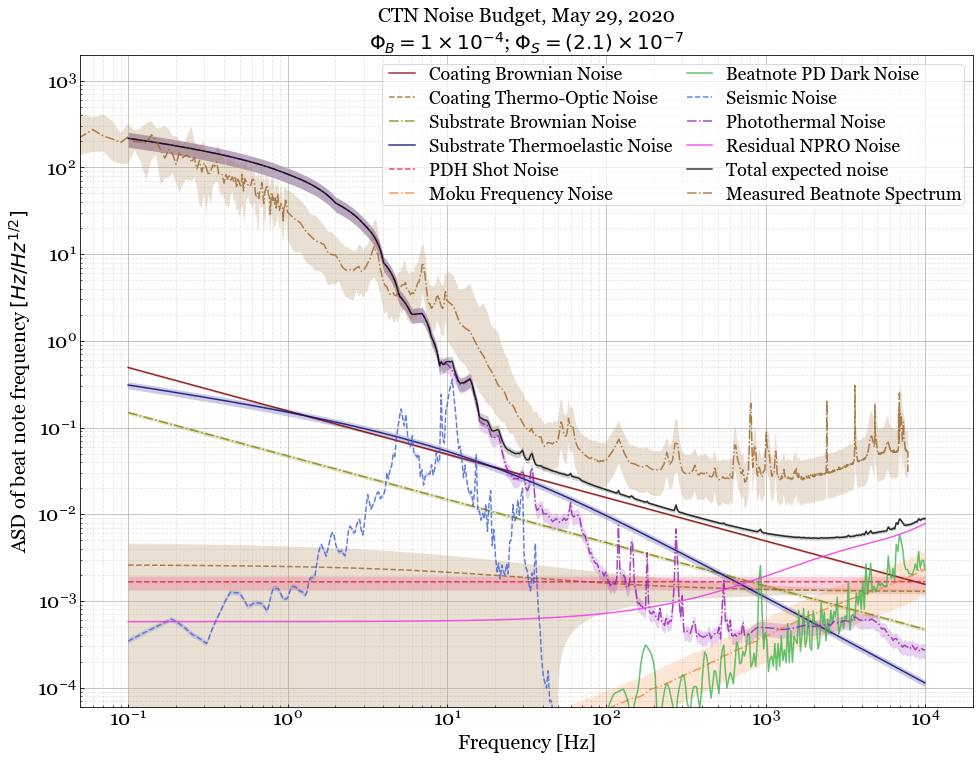

In [9]:
plotList = ['coatBr', 'coatTO', 'subBr', 'subTE',
            'pdhShot', 'pllOsc', 'pllReadout', 'seismic',
            'photoThermal', 'resNPRO', 'total', 'beat']
fig = nosbud.plotPSD(plotList=plotList,
                     savePlot=False,
                     doTotal=True)
fn = BNfile.replace('.txt', '')
tstamp = fn[fn.find('Spectrum_')+9:]
tstruc = time.strptime(tstamp, '%Y%m%d_%H%M%S')
BNdate = time.strftime('%b %d, %Y', tstruc)
ax = fig.gca()
ax.set_title('CTN Noise Budget, '+BNdate+'\n'+r'$\Phi_B=1 \times10^{-4}$; $\Phi_S=(2.1) \times10^{-7}$')
ax.set_xlim([0.05, 2e4])

In [10]:
# Bulk
def S_Bk_red(freq, nosbud):
    S_Bk_num = (4*scc.Boltzmann*nosbud.temp*nosbud.coatStack.WaveLength
                        * (1 - nosbud.coatStack.Poisson
                           - 2*nosbud.coatStack.Poisson**2))
    S_Bk_den = (3*np.pi*freq*nosbud.coatStack.Young
                        * ((1 - nosbud.coatStack.Poisson)**2)
                        * nosbud.coatStack.Aeff)
            # Leaving out substrate from return value
    return (S_Bk_num/S_Bk_den)[0:-1]

# Shear
def S_Sk_red(freq, nosbud):
    S_Sk_num = (4*scc.Boltzmann*nosbud.temp*nosbud.coatStack.WaveLength
                        * (1 - nosbud.coatStack.Poisson
                           - 2*nosbud.coatStack.Poisson**2))
    S_Sk_den = (3*np.pi*freq*nosbud.coatStack.Young
                        * ((1 - nosbud.coatStack.Poisson)**2)
                        * nosbud.coatStack.Aeff)
            # Leaving out substrate from return value
    return (S_Sk_num/S_Sk_den)[0:-1]

def BulkContSlope(freq, nosbud):
    if isinstance(freq, Iterable):
        return unp.nominal_values(np.array([BulkContSlope(f, nosbud) for f in freq]))
    return nosbud.nom*(nosbud.fConv**2)*np.sum(nosbud.q_Bk*S_Bk_red(freq, nosbud))

def ShearContSlope(freq, nosbud):
    if isinstance(freq, Iterable):
        return unp.nominal_values(np.array([ShearContSlope(f, nosbud) for f in freq]))
    return nosbud.nom*(nosbud.fConv**2)*np.sum(nosbud.q_Sk*S_Sk_red(freq, nosbud))

In [11]:
# Normal distributed prior based on Penn et al. measurements
def priorNphiB(phiB):
    priorMean = 5.33e-4
    priorStd = 0.03e-4
    prefac = 1/np.sqrt(2*np.pi)/priorStd
    exp = np.exp(-0.5*((priorMean -phiB)/priorStd)**2)
    return -0.5*((priorMean -phiB)/priorStd)**2
    # return prefac*exp

def priorNphiS(phiS):
    priorMean = 2.6e-7
    priorStd = 2.6e-7
    prefac = 1/np.sqrt(2*np.pi)/priorStd
    exp = np.exp(-0.5*((priorMean -phiS)/priorStd)**2)
    return -0.5*((priorMean -phiS)/priorStd)**2
    # return prefac*exp

# Uniformly distributed prior
def priorUphiB(phiB):
    if phiB>0 and phiB<200e-5:
        P_B = 0 
    else:
        P_B = -np.inf
    return P_B
def priorUphiS(phiS):
    if phiS>0 and phiS<94e-7:
        P_S = 0
    else:
        P_S = -np.inf
    return P_S

def logprior(BulkLA, ShearLA):
    X, Y = np.meshgrid(BulkLA, ShearLA)
    logpriorDist = np.zeros(np.shape(X))
    for ii in range(len(ShearLA)):
        for jj in range(len(BulkLA)):
            logpriorDist[ii][jj] = priorUphiB(BulkLA[jj])# + priorNphiS(ShearLA[ii])
    return logpriorDist

In [12]:
def skewgaus(x, x0, sigma, skewness, prefac):
    return prefac*skewnorm.pdf(x, skewness, loc=x0, scale=sigma)

In [13]:
def tsDatatoWelchArray(tsData, noverlap=0, timeSeg=5, rebinSize=5, skip=3,
                       lowerCutoffFreq=70, upperCutoffFreq=600,
                       average='median'):
    timeSeries = tsData[:, 0]
    noiseSig = tsData[:, 1]
    SampleRate = 1/(timeSeries[1] - timeSeries[0])
    nperseg = int(timeSeg * SampleRate)
    #Sort data into rows with number in each row = to nperseg
    # length of columns
    col_len=0
    end_edge=nperseg
    if noverlap is None:
        noverlap = nperseg//2
    while(end_edge<len(noiseSig)):
        end_edge=end_edge+nperseg-noverlap
        col_len=col_len+1

    # make array of row length nperseg and column length however much data
    # will fit fully in row
    sorted_data = np.zeros((col_len,nperseg))

    # make array for PSD will have same col len but
    # row len = max freq/freq_spacing + 1
    # or (samplerate/2) /(samplerate/nperseg) + 1 which = nperseg/2 +1
    welch_array = np.zeros((col_len, nperseg//2 + 1))

    #Move through signal data array populating array
    next_start=0
    for ii in range(col_len):
        sorted_data[ii, :] = noiseSig[next_start: next_start+nperseg]
        next_start = next_start+nperseg-noverlap
        
    # Do row-wise welch
    for k in range(col_len):
        ff, welch_array[k, :] = signal.welch(sorted_data[k, :], SampleRate,
                                             window = 'hann',
                                             nperseg = nperseg,
                                             nfft = None, detrend = False,
                                             return_onesided = True,
                                             scaling = 'density', axis = -1,
                                             average = 'median')
    # Rebin to remove correlations
    redff = np.zeros(len(ff[skip:])//rebinSize)
    redWelchArr = np.zeros((col_len, len(redff)))
    for ii in range(len(redff)):
        startInd = skip + rebinSize * ii
        endInd = skip + rebinSize * (ii + 1)
        redff[ii] = np.mean(ff[startInd:endInd])
        for k in range(col_len):
            if average=='mean':
                redWelchArr[k, ii] = np.mean(welch_array[k, startInd:endInd])
            elif average=='median':
                redWelchArr[k, ii] = np.median(welch_array[k, startInd:endInd])
    
    # Reduce PSD to frequencies of interest
    redWelchArr = redWelchArr[:, redff>lowerCutoffFreq]
    redff = redff[redff>lowerCutoffFreq]
    redWelchArr = redWelchArr[:, redff<upperCutoffFreq]
    redff = redff[redff<upperCutoffFreq]
    
    return redff, redWelchArr


def logWAtoPSDDist(ff, logWelchArray, nbins=10):
    psd_dist = []
    for ii, f in enumerate(ff):
        logWA = logWelchArray[:, ii]
        hist, bin_edges = np.histogram(logWA, bins=nbins)
        hist = hist/np.max(hist)
        bin_centers = 0.5*(bin_edges[1:] + bin_edges[0:-1])
        Q1 = np.percentile(logWA, 25)
        Q2 = np.percentile(logWA, 50)
        Q3 = np.percentile(logWA, 75)
        skewEst = (Q1 + Q2 - 2*Q3)/(Q3 - Q1)
        popt, pcov = curve_fit(skewgaus, bin_centers, hist, p0=[np.mean(logWA),np.std(logWA), skewEst, 1])
        psd_dist += [[f, popt, logWA, hist, bin_centers]]
    return psd_dist

        
def tsDatatoPSDDist(tsData, noverlap=0, timeSeg=5, rebinSize=5, skip=3,
                    lowerCutoffFreq=70, upperCutoffFreq=600, nbins=10,
                    average='median'):
    ff, WelchArray = tsDatatoWelchArray(tsData, noverlap=noverlap,
                                        timeSeg=timeSeg, rebinSize=rebinSize,
                                        skip=skip, lowerCutoffFreq=lowerCutoffFreq,
                                        upperCutoffFreq=upperCutoffFreq,
                                        average=average)
    return logWAtoPSDDist(ff, np.log(WelchArray), nbins)


def tsFiletoPSDDist(tsfile, noverlap=0, timeSeg=5, rebinSize=5, skip=3,
                    lowerCutoffFreq=70, upperCutoffFreq=600, nbins=10,
                    average='median'):
    if isinstance(tsfile, np.ndarray):
        tsData = tsfile
    else:
        tsData = np.loadtxt(tsfile)
    psd_dist_1 = tsDatatoPSDDist(tsData, noverlap=noverlap, timeSeg=timeSeg,
                                 lowerCutoffFreq=lowerCutoffFreq, upperCutoffFreq=101,
                                 rebinSize=rebinSize, skip=skip, nbins=nbins,
                                 average=average)
    psd_dist_2 = tsDatatoPSDDist(tsData, noverlap=None, timeSeg=timeSeg/10,
                                 lowerCutoffFreq=101, upperCutoffFreq=upperCutoffFreq,
                                 rebinSize=rebinSize, skip=skip, nbins=nbins,
                                 average=average)
    return psd_dist_1 + psd_dist_2

In [14]:
def rem60HzHarm(psd_dist, remNeighbors=False):
    ff = np.array([ele[0] for ele in psd_dist])
    remInd = []
    # Remove any repeated index
    for ii in range(1, len(ff)):
        if ff[ii] == ff[ii-1]:
            remInd = list(set(remInd + [ii]))
            
    # Remove bad region known to have peaks due to RIN
    for ii in range(1, len(ff)):
        if ff[ii] > 260 and ff[ii] < 290:
            remInd = list(set(remInd + [ii]))
    
    # Remove 60 Hz harmonics and neighbours
    sixtyHarm = np.arange(60, 1000, 60)
    for har in sixtyHarm:
        if har > ff.min() and har < ff.max():
            if np.min(np.abs(ff - har)) < 1:
                closestInd = np.argmin(np.abs(ff - har))
                remInd = list(set(remInd + [closestInd]))
                if closestInd < len(ff)-1:
                    remInd = list(set(remInd + [closestInd + 1]))
                if closestInd > 0:
                    remInd = list(set(remInd + [closestInd - 1]))
    
    for ind in sorted(remInd, reverse=True):
        del psd_dist[ind]
    return psd_dist

In [15]:
tsfile = BNfile.replace('Spectrum', 'TimeSeries')
tsdata = np.loadtxt(tsfile)

In [305]:
ff1, WelchArray1 = tsDatatoWelchArray(tsdata, noverlap=None, timeSeg=5,
                                      upperCutoffFreq=101,
                                      average='median')
ff2, WelchArray2 = tsDatatoWelchArray(tsdata, noverlap=None, timeSeg=0.5,
                                      lowerCutoffFreq=101,
                                      average='median')

In [306]:
psd_dist2_1 = logWAtoPSDDist(ff1, np.log(WelchArray1))
psd_dist2_2 = logWAtoPSDDist(ff2, np.log(WelchArray2))

In [ ]:
psd_dist1 = tsFiletoPSDDist(tsdata, noverlap=0, average='median')

In [ ]:
psd_dist1 = rem60HzHarm(psd_dist1, remNeighbors=True)
ff = np.array([ele[0] for ele in psd_dist1])
ff

In [ ]:
psd_dist2 = tsFiletoPSDDist(tsdata, noverlap=None, average='median')

In [ ]:
psd_dist2HR = tsDatatoPSDDist(tsdata, noverlap=None, average='median', timeSeg=5)

In [ ]:
psd_dist2 = rem60HzHarm(psd_dist2, remNeighbors=True)
ff = np.array([ele[0] for ele in psd_dist2])
ff

In [ ]:
ff = np.array([ele[0] for ele in psd_dist2HR])
ff

In [313]:

ff = np.array([ele[0] for ele in psd_dist2])

psd_dist2func = []
for ele in psd_dist2:
    distFunc = skewnorm(a = ele[1][2], loc=ele[1][0], scale=ele[1][1])
    psd_dist2func += [[ele[0], distFunc, ele[2], ele[3], ele[4]]]

In [321]:
psd_dist2 =

In [320]:
psd_dist2[9][1]

array([-5.79872335,  0.83079175, -0.76842694,  1.77353228])

In [97]:
psd_dist3 = tsFiletoPSDDist(tsdata, noverlap=None)

In [127]:
psd_dist3 = rem60HzHarm(psd_dist3, remNeighbors=True)
ff = np.array([ele[0] for ele in psd_dist3])
ff

array([ 71.        ,  72.        ,  73.        ,  74.        ,
        75.        ,  76.        ,  77.        ,  78.        ,
        79.        ,  80.        ,  81.        ,  82.        ,
        83.        ,  84.        ,  85.        ,  86.        ,
        87.        ,  88.        ,  89.        ,  90.        ,
        91.        ,  92.        ,  93.        ,  94.        ,
        95.        ,  96.        ,  97.        ,  98.        ,
        99.        , 100.        , 140.00896057, 150.00960061,
       160.01024066, 200.01280082, 210.01344086, 220.0140809 ,
       320.02048131, 330.02112135, 340.02176139, 380.02432156,
       390.0249616 , 400.02560164, 440.0281618 , 450.02880184,
       460.02944188, 500.03200205, 510.03264209, 520.03328213,
       560.03584229, 570.03648233, 580.03712238, 590.03776242])

In [123]:
tsfile = BNfile.replace('Spectrum', 'TimeSeries')
psd_dist4 = tsFiletoPSDDist(tsdata, noverlap=None, timeSeg=1, rebinSize=1, skip=0)

In [126]:
psd_dist4 = rem60HzHarm(psd_dist4, remNeighbors=True)
ff = np.array([ele[0] for ele in psd_dist4])
ff

array([ 71.        ,  72.        ,  73.        ,  74.        ,
        75.        ,  76.        ,  77.        ,  78.        ,
        79.        ,  80.        ,  81.        ,  82.        ,
        83.        ,  84.        ,  85.        ,  86.        ,
        87.        ,  88.        ,  89.        ,  90.        ,
        91.        ,  92.        ,  93.        ,  94.        ,
        95.        ,  96.        ,  97.        ,  98.        ,
        99.        , 100.        , 140.04481434, 150.04801536,
       160.05121639, 200.06402049, 210.06722151, 220.07042254,
       320.10243278, 330.1056338 , 340.10883483, 380.12163892,
       390.12483995, 400.12804097, 440.14084507, 450.14404609,
       460.14724712, 500.16005122, 510.16325224, 520.16645327,
       560.17925736, 570.18245839, 580.18565941, 590.18886044])

In [102]:
BNdata = np.loadtxt(BNfile)
ffclean, BNdataclean, x = cleanData(BNdata[:, 0], BNdata[:, 1], BNdata[:, 0])
ffclean

array([ 71.        ,  72.        ,  73.        ,  74.        ,
        75.        ,  76.        ,  77.        ,  78.        ,
        79.        ,  80.        ,  81.        ,  82.        ,
        83.        ,  84.        ,  85.        ,  86.        ,
        87.        ,  88.        ,  89.        ,  90.        ,
        91.        ,  92.        ,  93.        ,  94.        ,
        95.        ,  96.        ,  97.        ,  98.        ,
        99.        , 100.03201024, 140.04481434, 150.04801536,
       160.05121639, 200.06402049, 210.06722151, 220.07042254,
       320.10243278, 330.1056338 , 340.10883483, 380.12163892,
       390.12483995, 400.12804097, 440.14084507, 450.14404609,
       460.14724712, 500.16005122, 510.16325224, 520.16645327,
       560.17925736, 570.18245839, 580.18565941, 590.18886044])

In [29]:
def Srest(freq, nosbud):
    rest = ['coatTO', 'subBr', 'subTE', 'pdhShot',
            'pllOsc', 'pllReadout', 'seismic', 'photoThermal','resNPRO']
    S_rest = np.zeros_like(freq)
    for psd in rest:
        PSDest = unp.nominal_values(nosbud.PSDList[psd][0])
        S_rest = S_rest + np.interp(freq, nosbud.freq, PSDest)
    return S_rest

In [30]:
def loggaus(x, mean, std):
    return -0.5 * ((x - mean) / std)**2

In [331]:
psd_dist2[0][1]

array([-5.4957089 ,  0.90167421, -1.13130218,  1.81078035])

In [328]:
def loglikelihood(BulkLA, ShearLA, BNfile, nosbud,
                  psd_dist=None, useBNfileOnly=False, useLog=True):
    X, Y = np.meshgrid(BulkLA, ShearLA)
    loglkhDist = np.zeros_like(X)
    tsfile = BNfile.replace('Spectrum', 'TimeSeries')
    if ((os.path.exists(tsfile) 
         or psd_dist is not None)
        and not useBNfileOnly):
        if psd_dist is None:
            psd_dist = tsFiletoPSDDist(tsfile)
        psd_dist = rem60HzHarm(psd_dist)
        ff = np.array([ele[0] for ele in psd_dist])
        S_rest = Srest(ff, nosbud)
        X_B = BulkContSlope(ff, nosbud)
        X_S = ShearContSlope(ff, nosbud)
        ct = 0
        perc = 0
        for ii in range(len(ShearLA)):
            for jj in range(len(BulkLA)):
                estArr = np.log(S_rest + X_B * BulkLA[jj] + X_S * ShearLA[ii])
                for kk, element in enumerate(psd_dist):
                    if isinstance(element[1], np.ndarray):
                        loglkhDist[ii, jj] += np.log(skewgaus(estArr[kk], *element[1]))
                    else:
                        loglkhDist[ii, jj] += element[1].logpdf(estArr[kk])
                ct = ct + 1
                lastperc = perc
                perc = np.round(ct*100/len(ShearLA)/len(BulkLA))
                if perc != lastperc:
                    clear_output()
                    print('{}% Completed'.format(perc))
                    sys.stdout.flush()
        return loglkhDist
    else:
        data = np.loadtxt(BNfile)
        ff = data[:, 0]
        if useLog:
            measLogPSD = np.log(data[:, 1]**2)
            measLogPSDstd = (np.log(data[:, 3]**2) - np.log(data[:, 2]**2))/2
            ff, measLogPSD, measLogPSDstd = cleanData(ff, measLogPSD, measLogPSDstd)
        else:
            measPSD = data[:, 1]**2
            measPSDstd = (data[:, 3]**2 -data[:, 2]**2)/2
            ff, measPSD, measPSDstd = cleanData(ff, measPSD, measPSDstd)
        S_rest = Srest(ff, nosbud)
        X_B = BulkContSlope(ff, nosbud)
        X_S = ShearContSlope(ff, nosbud)
        ct = 0
        perc = 0
        for ii in range(len(ShearLA)):
            for jj in range(len(BulkLA)):
                if useLog:
                    estArr = np.log(S_rest + X_B * BulkLA[jj] + X_S * ShearLA[ii])
                    loglkhDist[ii, jj] = np.sum(loggaus(estArr, measLogPSD, measLogPSDstd))
                else:
                    estArr = S_rest + X_B * BulkLA[jj] + X_S * ShearLA[ii]
                    loglkhDist[ii, jj] = np.sum(loggaus(estArr, measPSD, measPSDstd))
                ct = ct + 1
                lastperc = perc
                perc = np.round(ct*100/len(ShearLA)/len(BulkLA))
                if perc != lastperc:
                    clear_output()
                    print('{}% Completed'.format(perc))
                    sys.stdout.flush()
        return loglkhDist
        

In [271]:
from scipy.optimize import curve_fit

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))



new_dist1 = []
nbins = 10
for element in psd_dist1:
    if element[0] > 40 and element[0] < 700:
        logWA = element[2]
        hist, bin_edges = np.histogram(logWA, bins=10)
        hist = hist/np.max(hist)
        bin_centers = 0.5*(bin_edges[1:] + bin_edges[0:-1])
        Q1 = np.percentile(logWA, 25)
        Q2 = np.percentile(logWA, 50)
        Q3 = np.percentile(logWA, 75)
        skewEst = (Q1 + Q2 - 2*Q3)/(Q3 - Q1)
        popt,pcov = curve_fit(skewgaus, bin_centers, hist, p0=[np.mean(logWA),np.std(logWA), skewEst, 1])
        new_dist1 += [[element[0], popt, logWA,
                       np.mean(logWA), np.median(logWA),
                       hist, bin_centers]]

new_dist2 = []
nbins = 10
for element in psd_dist2:
    if element[0] > 40 and element[0] < 700:
        logWA = element[2]
        hist, bin_edges = np.histogram(logWA, bins=10)
        hist = hist/np.max(hist)
        bin_centers = 0.5*(bin_edges[1:] + bin_edges[0:-1])
        Q1 = np.percentile(logWA, 25)
        Q2 = np.percentile(logWA, 50)
        Q3 = np.percentile(logWA, 75)
        skewEst = (Q1 + Q2 - 2*Q3)/(Q3 - Q1)
        popt,pcov = curve_fit(skewgaus, bin_centers, hist, p0=[np.mean(logWA),np.std(logWA), skewEst, 1])
        new_dist2 += [[element[0], popt, logWA,
                       np.mean(logWA), np.median(logWA),
                       hist, bin_centers]]
new_dist3 = []
nbins = 10
for element in psd_dist3:
    if element[0] > 40 and element[0] < 700:
        logWA = element[2]
        hist, bin_edges = np.histogram(logWA, bins=20)
        hist = hist/np.max(hist)
        bin_centers = 0.5*(bin_edges[1:] + bin_edges[0:-1])
        Q1 = np.percentile(logWA, 25)
        Q2 = np.percentile(logWA, 50)
        Q3 = np.percentile(logWA, 75)
        skewEst = (Q1 + Q2 - 2*Q3)/(Q3 - Q1)
        popt,pcov = curve_fit(skewgaus, bin_centers, hist, p0=[np.mean(logWA),np.std(logWA), skewEst, 1])
        new_dist3 += [[element[0], popt, logWA,
                       np.mean(logWA), np.median(logWA),
                       hist, bin_centers]]
        
new_dist4 = []
nbins = 10
for element in psd_dist4:
    if element[0] > 40 and element[0] < 700:
        logWA = element[2]
        hist, bin_edges = np.histogram(logWA, bins=40)
        hist = hist/np.max(hist)
        bin_centers = 0.5*(bin_edges[1:] + bin_edges[0:-1])
        Q1 = np.percentile(logWA, 25)
        Q2 = np.percentile(logWA, 50)
        Q3 = np.percentile(logWA, 75)
        skewEst = (Q1 + Q2 - 2*Q3)/(Q3 - Q1)
        popt,pcov = curve_fit(gaus, bin_centers, hist,
                              p0=[1, np.mean(logWA),np.std(logWA)],
                              maxfev=10000)
        new_dist4 += [[element[0], popt[1:], logWA,
                       np.mean(logWA), np.median(logWA),
                       hist, bin_centers]]

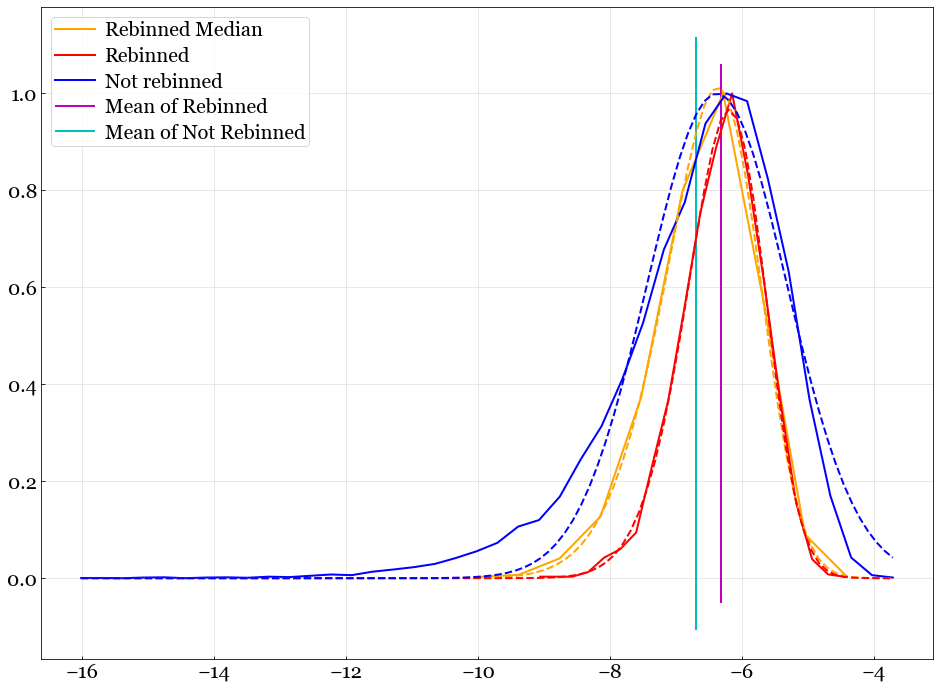

In [266]:
ffind = 30
fig = plt.figure()
ax = fig.gca()
x1 = new_dist1[ffind][6]
x2 = new_dist2[ffind][6]
x3 = new_dist3[ffind][6]
x4 = new_dist4[ffind][6]
xaxis = np.linspace(min(x3.min(), x4.min()), max(x3.max(), x4.max()), 100)
popt1 = new_dist1[ffind][1]
popt2 = new_dist2[ffind][1]
popt3 = new_dist3[ffind][1]
popt4 = new_dist4[ffind][1]
ax.plot(x2, new_dist2[ffind][5], c='orange', label='Rebinned Median')
ax.plot(x3, new_dist3[ffind][5], c='r', label='Rebinned')
ax.plot(x4, new_dist4[ffind][5], c='b', label='Not rebinned')
ax.plot(xaxis,
        skewgaus(xaxis, *popt2),
        c='orange', ls='--')
ax.plot(xaxis,
        skewgaus(xaxis, *popt3),
        c='r', ls='--')
ax.plot(xaxis,
        gaus(xaxis, 1,  popt4[0], popt4[1]),
        c='b', ls='--')
ax.vlines(new_dist3[ffind][3], ax.get_ylim()[0], ax.get_ylim()[1],
          color='m', label='Mean of Rebinned')
ax.vlines(new_dist4[ffind][3], ax.get_ylim()[0], ax.get_ylim()[1],
          color='c', label='Mean of Not Rebinned')
ax.legend()

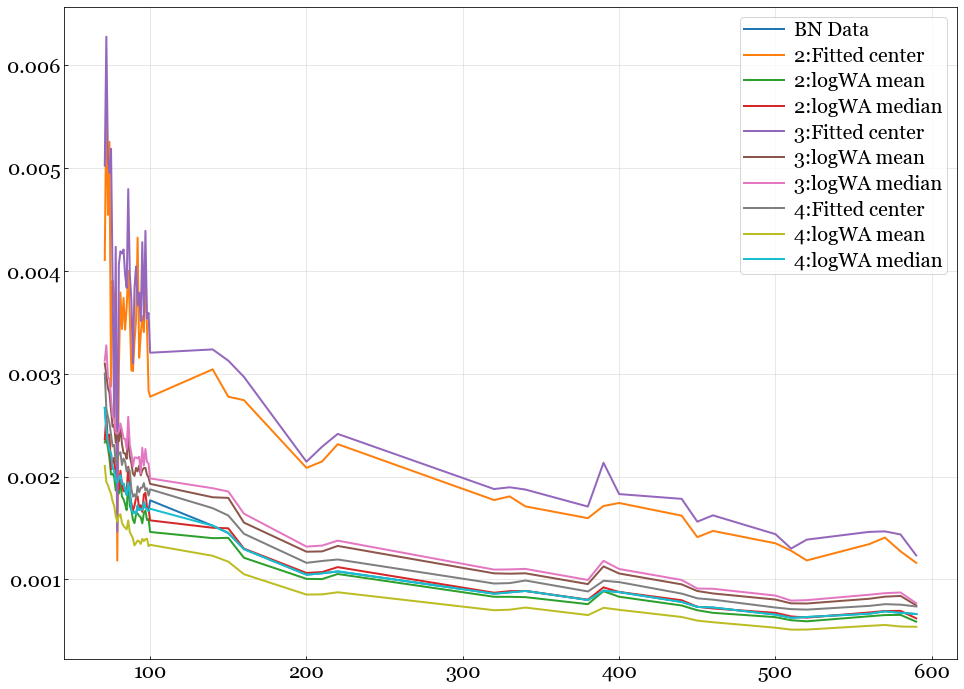

In [267]:
ff = np.array([ele[0] for ele in new_dist3])
new_dist2_m = np.array([ele[1][0] for ele in new_dist2])
new_dist2_mean = np.array([ele[3] for ele in new_dist2])
new_dist2_median = np.array([ele[4] for ele in new_dist2])
new_dist3_m = np.array([ele[1][0] for ele in new_dist3])
new_dist3_mean = np.array([ele[3] for ele in new_dist3])
new_dist3_median = np.array([ele[4] for ele in new_dist3])
ff4 = np.array([ele[0] for ele in new_dist4])
new_dist4_m = np.array([ele[1][0] for ele in new_dist4])
new_dist4_mean = np.array([ele[3] for ele in new_dist4])
new_dist4_median = np.array([ele[4] for ele in new_dist4])
fig = plt.figure()
ax = fig.gca()
ax.plot(ffclean, BNdataclean**2, label='BN Data')
ax.plot(ff, np.exp(new_dist2_m), label='2:Fitted center')
ax.plot(ff, np.exp(new_dist2_mean), label='2:logWA mean')
ax.plot(ff, np.exp(new_dist2_median), label='2:logWA median')
ax.plot(ff, np.exp(new_dist3_m), label='3:Fitted center')
ax.plot(ff, np.exp(new_dist3_mean), label='3:logWA mean')
ax.plot(ff, np.exp(new_dist3_median), label='3:logWA median')
ax.plot(ff4, np.exp(new_dist4_m), label='4:Fitted center')
ax.plot(ff4, np.exp(new_dist4_mean), label='4:logWA mean')
ax.plot(ff4, np.exp(new_dist4_median), label='4:logWA median')
ax.legend()

In [329]:
BulkLA = np.arange(3e-4, 20e-4, 1e-6)
ShearLA = np.array([5.2e-7])
priorDist = logprior(BulkLA, ShearLA)
#lkhDist = loglikelihood(BulkLA, ShearLA, BNfile, nosbud, useBNfileOnly=True)
#lkhDist2 = loglikelihood(BulkLA, ShearLA, BNfile, nosbud, psd_dist4)
#lkhDist21 = loglikelihood(BulkLA, ShearLA, BNfile, nosbud, new_dist4)
#lkhDist22 = loglikelihood(BulkLA, ShearLA, BNfile, nosbud, new_dist3)
lkhDist23 = loglikelihood(BulkLA, ShearLA, BNfile, nosbud, psd_dist2)
#lkhDist24 = loglikelihood(BulkLA, ShearLA, BNfile, nosbud, new_dist1)
#lkhDist25 = loglikelihood(BulkLA, ShearLA, BNfile, nosbud, psd_dist2func)
#lkhDist3 = loglikelihood(BulkLA, ShearLA, BNfile, nosbud, useBNfileOnly=True, useLog=False)
bayProbDist2 = priorDist + lkhDist2
bayProbDist21 = priorDist + lkhDist21
bayProbDist22 = priorDist + lkhDist22
bayProbDist23 = priorDist + lkhDist23
bayProbDist24 = priorDist + lkhDist24
bayProbDist25 = priorDist + lkhDist25
bayProbDist = priorDist + lkhDist
bayProbDist3 = priorDist + lkhDist3

TypeError: skewgaus() argument after * must be an iterable, not rv_histogram

In [315]:
mlBLAind23 = np.argmax(bayProbDist23[0, :])
print(BulkLA[mlBLAind23]*1e4)
mlBLAind24 = np.argmax(bayProbDist24[0, :])
print(BulkLA[mlBLAind24]*1e4)
mlBLAind25 = np.argmax(bayProbDist25[0, :])
print(BulkLA[mlBLAind25]*1e4)

8.81000000000014
8.970000000000145
8.81000000000014


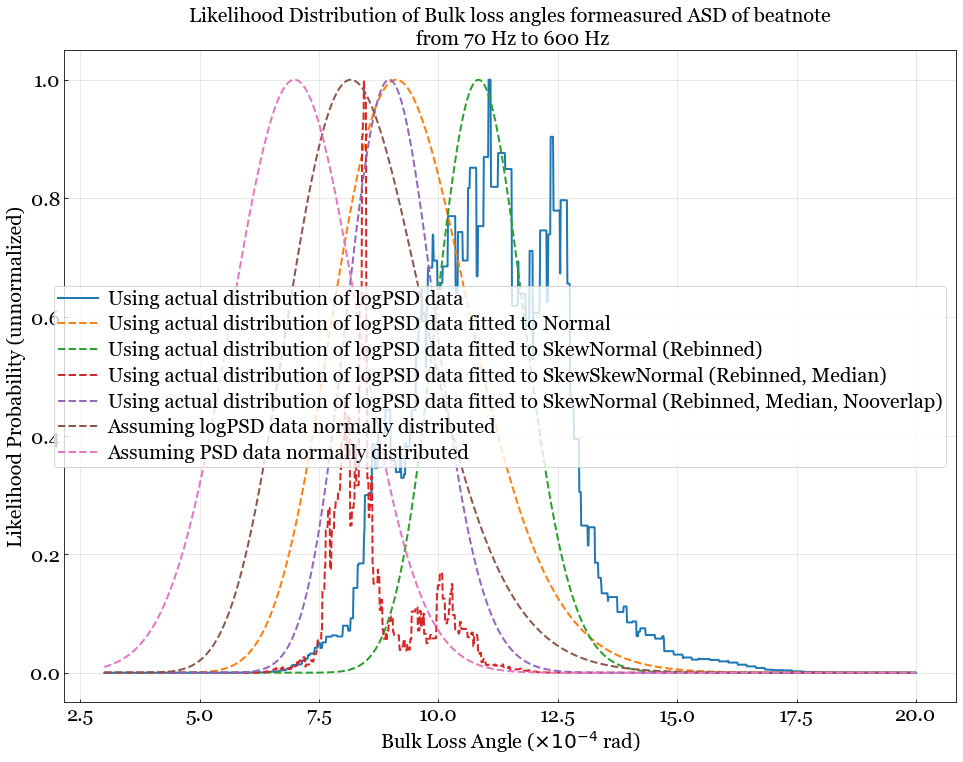

In [283]:
fig = plt.figure(figsize=[16,12])
ax = fig.gca()
explkhDist = np.exp(lkhDist[0, :])/np.max(np.exp(lkhDist[0, :]))
explkhDist2 = np.exp(lkhDist2[0, :])/np.max(np.exp(lkhDist2[0, :]))
explkhDist21 = np.exp(lkhDist21[0, :])/np.max(np.exp(lkhDist21[0, :]))
explkhDist22 = np.exp(lkhDist22[0, :])/np.max(np.exp(lkhDist22[0, :]))
explkhDist23 = np.exp(lkhDist23[0, :])/np.max(np.exp(lkhDist23[0, :]))
explkhDist24 = np.exp(lkhDist24[0, :])/np.max(np.exp(lkhDist24[0, :]))
explkhDist3 = np.exp(lkhDist3[0, :])/np.max(np.exp(lkhDist3[0, :]))
ax.plot(BulkLA * 1e4, explkhDist2, label = 'Using actual distribution of logPSD data')
ax.plot(BulkLA * 1e4, explkhDist21,
        label = 'Using actual distribution of logPSD data fitted to Normal', ls='--')
ax.plot(BulkLA * 1e4, explkhDist22,
        label = 'Using actual distribution of logPSD data fitted to SkewNormal (Rebinned)', ls='--')
ax.plot(BulkLA * 1e4, explkhDist23,
        label = 'Using actual distribution of logPSD data fitted to SkewSkewNormal (Rebinned, Median)', ls='--')
ax.plot(BulkLA * 1e4, explkhDist24,
        label = 'Using actual distribution of logPSD data fitted to SkewNormal (Rebinned, Median, Nooverlap)', ls='--')
ax.plot(BulkLA * 1e4, explkhDist, label = 'Assuming logPSD data normally distributed', ls='--')
ax.plot(BulkLA * 1e4, explkhDist3, label = 'Assuming PSD data normally distributed', ls='--')
ax.set_title('Likelihood Distribution of Bulk loss angles for'
             'measured ASD of beatnote\n from 70 Hz to 600 Hz')
ax.set_xlabel('Bulk Loss Angle (' + r'$\times 10^{-4}$' + ' rad)')
ax.set_ylabel('Likelihood Probability (unnormalized)')
ax.legend()
figlist += [fig]

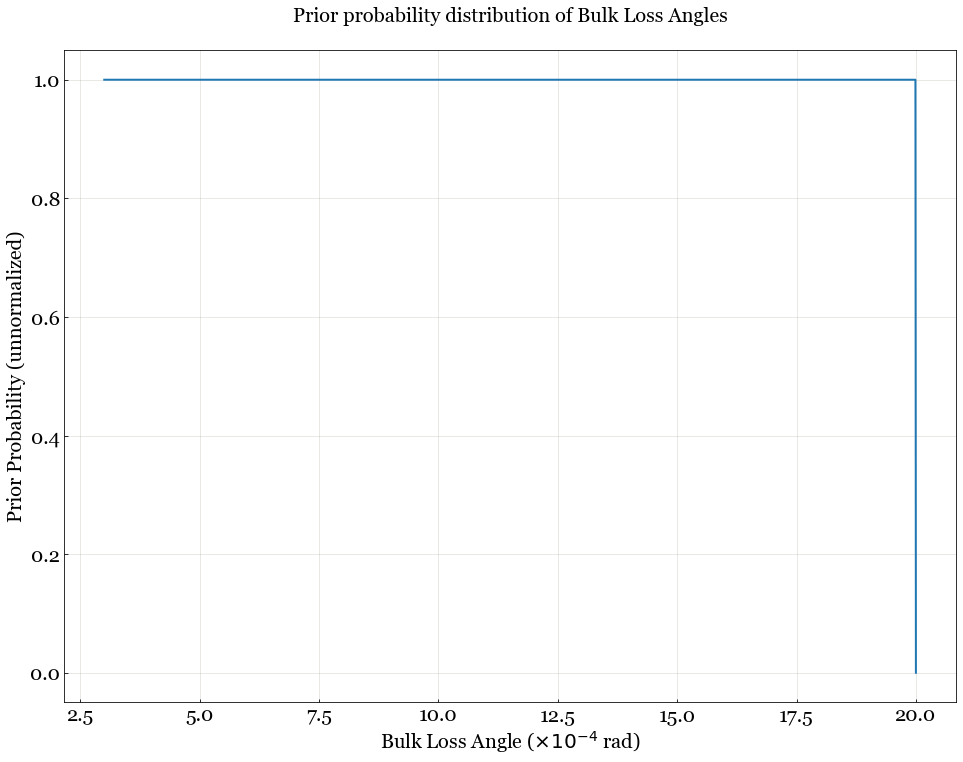

In [450]:
fig = plt.figure(figsize=[16,12])
ax = fig.gca()
ax.plot(BulkLA * 1e4, np.exp(priorDist[0, :]))
ax.set_title('Prior probability distribution of Bulk Loss Angles\n')
ax.set_xlabel('Bulk Loss Angle (' + r'$\times 10^{-4}$' + ' rad)')
ax.set_ylabel('Prior Probability (unnormalized)')
figlist = [fig]

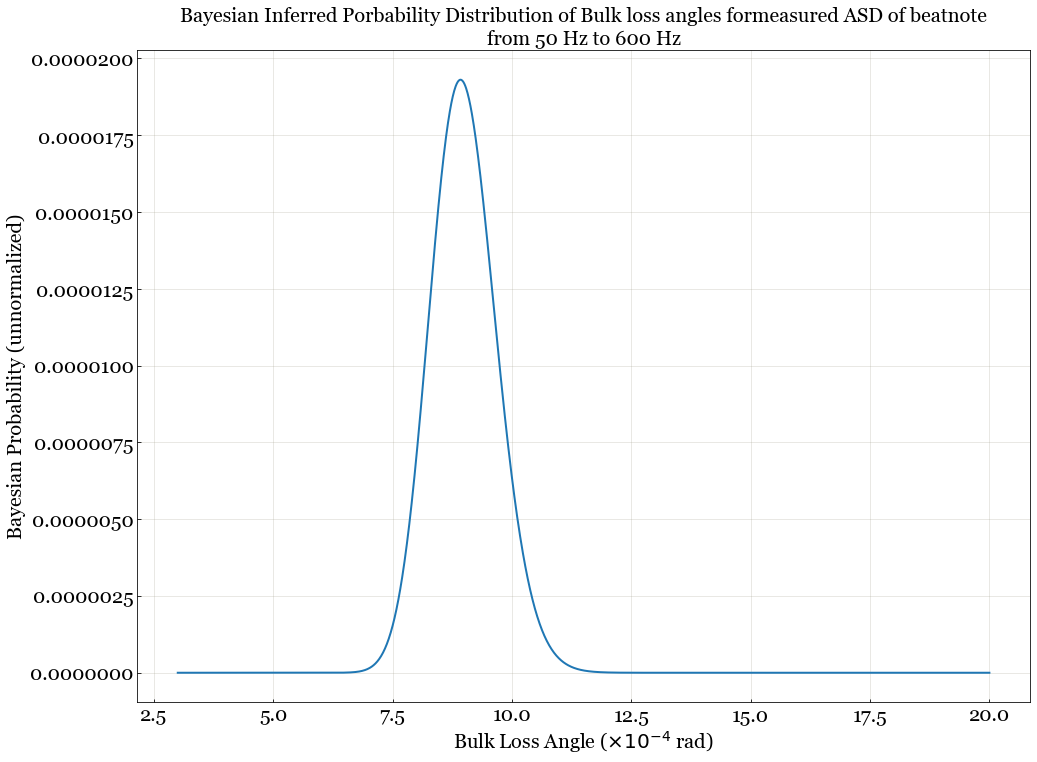

In [451]:
fig = plt.figure(figsize=[16,12])
ax = fig.gca()
ax.plot(BulkLA * 1e4, np.exp(bayProbDist[0, :]),
        label = 'Using actual distribution of logPSD data')
ax.set_title('Bayesian Inferred Porbability Distribution of Bulk loss angles for'
             'measured ASD of beatnote\nfrom 50 Hz to 600 Hz')
ax.set_xlabel('Bulk Loss Angle (' + r'$\times 10^{-4}$' + ' rad)')
ax.set_ylabel('Bayesian Probability (unnormalized)')
figlist += [fig]

In [138]:
mlBLAind = np.argmax(bayProbDist[0, :])
mlBLA = BulkLA[mlBLAind]
totArea = np.sum(np.exp(bayProbDist[0, :]))
for ii in range(1, len(BulkLA)//2):
    if np.sum(np.exp(bayProbDist[0, mlBLAind-ii:mlBLAind+ii])) > 0.9*totArea:
        BLAci90ll = BulkLA[mlBLAind - ii + 1]
        BLAci90ul = BulkLA[mlBLAind + ii - 1]
        BLAci90pm = (BLAci90ul - BLAci90ll)/2
        break

In [139]:
mlBLAind3 = np.argmax(bayProbDist3[0, :])
mlBLA3 = BulkLA[mlBLAind3]
totArea3 = np.sum(np.exp(bayProbDist3[0, :]))
for ii in range(1, len(BulkLA)//2):
    if np.sum(np.exp(bayProbDist3[0, mlBLAind3-ii:mlBLAind3+ii])) > 0.9*totArea3:
        BLAci90ll3 = BulkLA[mlBLAind3 - ii + 1]
        BLAci90ul3 = BulkLA[mlBLAind3 + ii - 1]
        BLAci90pm3 = (BLAci90ul3 - BLAci90ll3)/2
        break

In [144]:
mlBLAind21 = np.argmax(bayProbDist21[0, :])
mlBLA21 = BulkLA[mlBLAind21]
totArea21 = np.sum(np.exp(bayProbDist21[0, :]))
for ii in range(1, len(BulkLA)//2):
    if np.sum(np.exp(bayProbDist21[0, mlBLAind21-ii:mlBLAind21+ii])) > 0.9*totArea21:
        BLAci90ll21 = BulkLA[mlBLAind21 - ii + 1]
        BLAci90ul21 = BulkLA[mlBLAind21 + ii - 1]
        BLAci90pm21 = (BLAci90ul21 - BLAci90ll21)/2
        break

In [145]:
mlBLAind22 = np.argmax(bayProbDist22[0, :])
mlBLA22 = BulkLA[mlBLAind22]
totArea22 = np.sum(np.exp(bayProbDist22[0, :]))
for ii in range(1, len(BulkLA)//2):
    if np.sum(np.exp(bayProbDist22[0, mlBLAind22-ii:mlBLAind22+ii])) > 0.9*totArea22:
        BLAci90ll22 = BulkLA[mlBLAind22 - ii + 1]
        BLAci90ul22 = BulkLA[mlBLAind22 + ii - 1]
        BLAci90pm22 = (BLAci90ul22 - BLAci90ll22)/2
        break

In [250]:
bayProbDist23 = priorDist + lkhDist23
mlBLAind23 = np.argmax(bayProbDist23[0, :])
mlBLA23 = BulkLA[mlBLAind23]
totArea23 = np.sum(np.exp(bayProbDist23[0, :]))
for ii in range(1, len(BulkLA)//2):
    if np.sum(np.exp(bayProbDist23[0, mlBLAind23-ii:mlBLAind23+ii])) > 0.9*totArea23:
        BLAci90ll23 = BulkLA[mlBLAind23 - ii + 1]
        BLAci90ul23 = BulkLA[mlBLAind23 + ii - 1]
        BLAci90pm23 = (BLAci90ul23 - BLAci90ll23)/2
        break

In [241]:
print('Estimated Bulk Loss Angle {:.2e} +- {:.2e} radians assuming logPSD is normal'.format(mlBLA, BLAci90pm))

Estimated Bulk Loss Angle 8.16e-04 +- 2.45e-04 radians assuming logPSD is normal


In [242]:
print('Estimated Bulk Loss Angle {:.2e} +- {:.2e} radians assuming PSD is normal'.format(mlBLA3, BLAci90pm3))

Estimated Bulk Loss Angle 6.98e-04 +- 2.14e-04 radians assuming PSD is normal


In [243]:
print('Estimated Bulk Loss Angle {:.2e} +- {:.2e} radians using normal fit of logPSD'.format(mlBLA21, BLAci90pm21))

Estimated Bulk Loss Angle 9.06e-04 +- 2.46e-04 radians using normal fit of logPSD


In [244]:
print('Estimated Bulk Loss Angle {:.2e} +- {:.2e} radians using skew-normal fit of logPSD (rebined, median)'.format(mlBLA23, BLAci90pm23))

Estimated Bulk Loss Angle 8.90e-04 +- 1.51e-04 radians using skew-normal fit of logPSD (rebined, median)


In [456]:
nosbud.coatStack.Loss = mlBLA 
nosbud.coatStack.LossShear = 5.2e-7
nosbud.coatStack.HongBrownianCoeffCalculations(nosbud.lam)
nosbud.coatStack.EvanThermoOpticCoeffCalculations(nosbud.lam)
nosbud.calculateCoatingBrownianNoise();

Using Hong et al . PRD 87, 082001 (2013) to calculate parameters for coating brownian noise
Wait 1 to 2 minutes ...
Using Evans et al . PRD 78, 102003 (2008) to calculatecoefficients for thermo-optic noise
Wait 30 to 90 seconds ...
Using Hong et al . PRD 87, 082001 (2013) to calculate coating brownian noise.
Typical calculation time is approximately 14 min.


Text(0.5, 1.0, '')

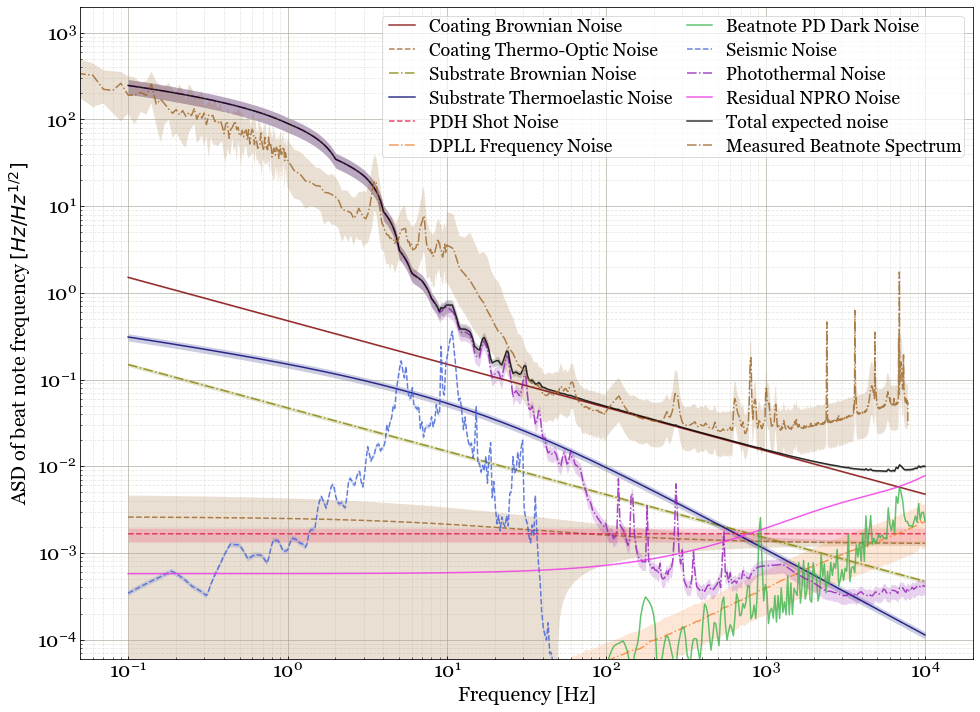

In [306]:
plotList = ['coatBr', 'coatTO', 'subBr', 'subTE',
            'pdhShot', 'pllOsc', 'pllReadout', 'seismic',
            'photoThermal', 'resNPRO', 'total', 'beat']
nosbud.PSDList['pllOsc'][2] = 'DPLL Frequency Noise'
fig = nosbud.plotPSD(plotList=plotList,
                     savePlot=False,
                     doTotal=True)
fn = BNfile.replace('.txt', '')
tstamp = fn[fn.find('Spectrum_')+9:]
tstruc = time.strptime(tstamp, '%Y%m%d_%H%M%S')
BNdate = time.strftime('%b %d, %Y', tstruc)
ax = fig.gca()
ax.set_xlim([0.05, 2e4])
ax.set_title('')

In [23]:
#fig.savefig('/Users/anchal/Git/writing-presenting/CTN_DAMOP_Poster/figures/CTN_Noise_Budget.pdf',
#            facecolor=fig.get_facecolor(),
#            bbox_inches='tight')

In [24]:
ax.set_title('CTN Noise Budget, '
             + BNdate
             + '\n'
             + r'$\Phi_{B}$'
             + ' = {:.2f} '.format(mlBLA*1e4)
             + r'$\pm$' + ' {:.2f} '.format(BLAci90pm*1e4)
             + r'$ \times 10^{-4}$' + ' radians; '
             + r'$\Phi_{S} = 5.2 \times 10^{-7}$' + ' radians')
figlist += [fig]

In [25]:
#pp = PdfPages('CTN_Bayesian_Inference_Analysis_Of_Best_Result_New.pdf')
#for fig in figlist:
#    pp.savefig(fig, bbox_inches='tight')
#pp.close()

In [480]:
from modifiedPSD2 import modPSD2
def creatPSDfile2(origBNfile):
    newBNfile = os.path.split(origBNfile)[1]
    dataFileName = origBNfile.replace('Spectrum', 'TimeSeries')
    tsdata = np.loadtxt(dataFileName)
    Freq, PSD, lowB, uppB = modPSD2(tsdata[:, 0], tsdata[:, 1],
                                    average = 'median')
    saveData = np.zeros((len(Freq),4))
    ASD = np.sqrt(PSD)
    ASDlb = np.sqrt(lowB)
    ASDub = np.sqrt(uppB)
    saveData[:,0] = Freq
    saveData[:,1] = ASD
    saveData[:,2] = ASDlb
    saveData[:,3] = ASDub
    header = []
    with open(dataFileName,'r') as f:
        for line in f.readlines():
            if line[0] is '#':
                header += [line+'\n']
    np.savetxt(newBNfile, saveData, header=''.join(header))
    return newBNfile

In [481]:
newBNfile = creatPSDfile2(BNfile)

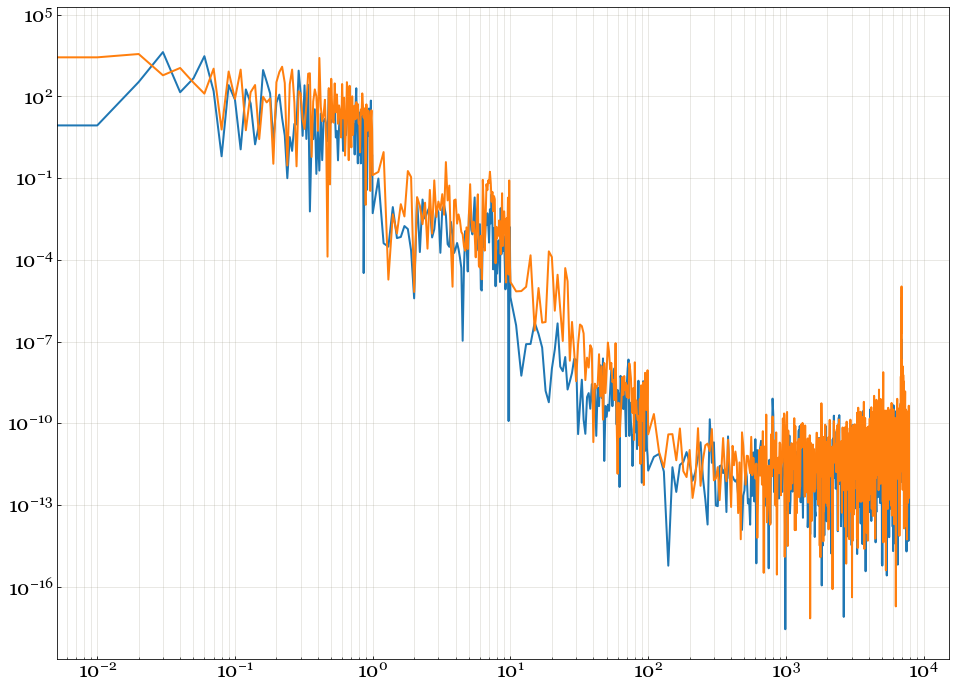

In [511]:
plt.loglog(np.loadtxt(BNfile)[:, 0], np.abs(np.loadtxt(newBNfile)[:, 2]**2 - np.loadtxt(BNfile)[:, 2]**2))
plt.loglog(np.loadtxt(BNfile)[:, 0], np.abs(np.loadtxt(newBNfile)[:, 3]**2 - np.loadtxt(BNfile)[:, 3]**2))